In [3]:
library("tidyverse")
library("cowplot")
library("FactoMineR")
library("factoextra")
library("RColorBrewer")
library("umap")
library("patchwork")
set.seed(42)
# import filtered count tables and metatables
setwd("/home/vanda/Documents/PanBarley_transcriptome/01_vsdTPMs_peraccession/")
fnames <- list.files(pattern = "*_vsdTPM.csv")
vsdlist = list()
collist = list()
# first create an overlap of common hogs across all accessions
for (i in fnames) {
    vsd_df <- read.table(i, row.names = 1, header = TRUE, sep = ",", stringsAsFactors = FALSE)
    vsd_t <- as.data.frame(t(vsd_df), stringsAsFactors = TRUE) %>% rownames_to_column("ID")
    cols <- colnames(vsd_t)
    collist[[i]] <- cols
}
str(collist)
common_hogs <- Reduce(intersect, collist)
str(common_hogs)
# there are 11,816 commonly highly expressed hogs
for (i in fnames) {
    vsd_df <- read.table(i, row.names = 1, header = TRUE, sep = ",", stringsAsFactors = FALSE)
    vsd_t <- as.data.frame(t(vsd_df), stringsAsFactors = TRUE) %>% 
                rownames_to_column("ID") %>%
                select(matches(common_hogs))
    vsdlist[[i]] <- vsd_t
}
all_vsd <- do.call(rbind, vsdlist)
dim(all_vsd)

List of 20
 $ Akashinriki_vsdTPM.csv  : chr [1:11835] "ID" "chr6H66186" "chr7H70574" "chr6H57235" ...
 $ B1K_vsdTPM.csv          : chr [1:11830] "ID" "chr6H66186" "chr7H70574" "chr6H57235" ...
 $ Barke_vsdTPM.csv        : chr [1:11834] "ID" "chr6H66186" "chr7H70574" "chr6H57235" ...
 $ GoldenPromise_vsdTPM.csv: chr [1:11833] "ID" "chr6H66186" "chr7H70574" "chr6H57235" ...
 $ Hockett_vsdTPM.csv      : chr [1:11834] "ID" "chr6H66186" "chr7H70574" "chr6H57235" ...
 $ HOR10350_vsdTPM.csv     : chr [1:11831] "ID" "chr6H66186" "chr7H70574" "chr6H57235" ...
 $ HOR13821_vsdTPM.csv     : chr [1:11832] "ID" "chr6H66186" "chr7H70574" "chr6H57235" ...
 $ HOR13942_vsdTPM.csv     : chr [1:11834] "ID" "chr6H66186" "chr7H70574" "chr6H57235" ...
 $ HOR21599_vsdTPM.csv     : chr [1:11834] "ID" "chr6H66186" "chr7H70574" "chr6H57235" ...
 $ HOR3081_vsdTPM.csv      : chr [1:11836] "ID" "chr6H66186" "chr7H70574" "chr6H57235" ...
 $ HOR3365_vsdTPM.csv      : chr [1:11833] "ID" "chr6H66186" "chr7H70574" "chr6

[1]   297 11817

In [7]:
setwd("/home/vanda/Documents/PanBarley_transcriptome/00_meta_peraccession/")
meta <- read.table("PanBaRT20_geneTPM_meta.csv", sep = ",", header = TRUE, stringsAsFactors = TRUE)
dim(meta)
head(meta, 3)
#####
# PCA
#####
cnt_pca <- inner_join(all_vsd, meta, by = "ID") %>%
                mutate(id = ID) %>% 
                column_to_rownames("ID") %>% 
                rename(ID = id) %>% 
                select(ID, Accession, Tissue, Batch, starts_with("chr"))

[1] 297   4

,ID,Accession,Tissue,Batch
,<fct>,<fct>,<fct>,<int>
1,Akashinriki_Ca1,Akashinriki,Caryopsis,1
2,Akashinriki_Ca2,Akashinriki,Caryopsis,2
3,Akashinriki_Ca3,Akashinriki,Caryopsis,3


In [9]:
# convert to factors
cols <- c("ID", "Accession", "Tissue", "Batch")
cnt_pca[cols] <- lapply(cnt_pca[cols], factor)
# drop extra factor levels
cnt_pca <- droplevels(cnt_pca)
# run pca
dim(cnt_pca)
pca <- PCA(X = cnt_pca, scale.unit = FALSE, ncp = 4, quali.sup = c(1:4), graph = F)

[1]   297 11820

In [13]:
# visualize
scree <- fviz_eig(pca, addlabels = TRUE)
pca1 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Tissue", title = "PanBarley variance stabilized TPM counts", addEllipses = FALSE, axes = c(1, 2), habillage = cnt_pca$Tissue, pointsize = 6) +
                scale_color_manual(values = c("#D91E36", "#611C35", "#2E5077", "#48A9A6", "#C4A69D"),
                                   limits = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                   labels = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root")) +
                scale_shape_manual(limits = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                   labels = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                      values = c(15,19,17,18,20)) +
                scale_fill_manual(values = c("#D91E36", "#611C35", "#2E5077", "#48A9A6", "#C4A69D"),
                                  limits = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                  labels = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root")) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    #legend.position=c(0.85, 0.7),
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC1") + 
                ylab("PC2")
pca2 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Tissue", title = "PanBarley variance stabilized TPM counts", addEllipses = FALSE, axes = c(3, 4), habillage = cnt_pca$Tissue, pointsize = 6) +
                scale_color_manual(values = c("#D91E36", "#611C35", "#2E5077", "#48A9A6", "#C4A69D"),
                                   limits = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                   labels = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root")) +
                scale_shape_manual(limits = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                   labels = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                      values = c(15,19,17,18,20)) +
                scale_fill_manual(values = c("#D91E36", "#611C35", "#2E5077", "#48A9A6", "#C4A69D"),
                                  limits = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                  labels = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root")) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    #legend.position=c(0.85, 0.7),
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC3") + 
                ylab("PC4")
pca3 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Accession", title = "PanBarley variance stabilized TPM counts", addEllipses = FALSE, axes = c(1, 2), habillage = cnt_pca$Accession, pointsize = 6) +
                scale_shape_manual(values = c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,23,25)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    #legend.position=c(0.85, 0.7),
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC1") + 
                ylab("PC2")

Scale for shape is already present.
Adding another scale for shape, which will replace the existing scale.


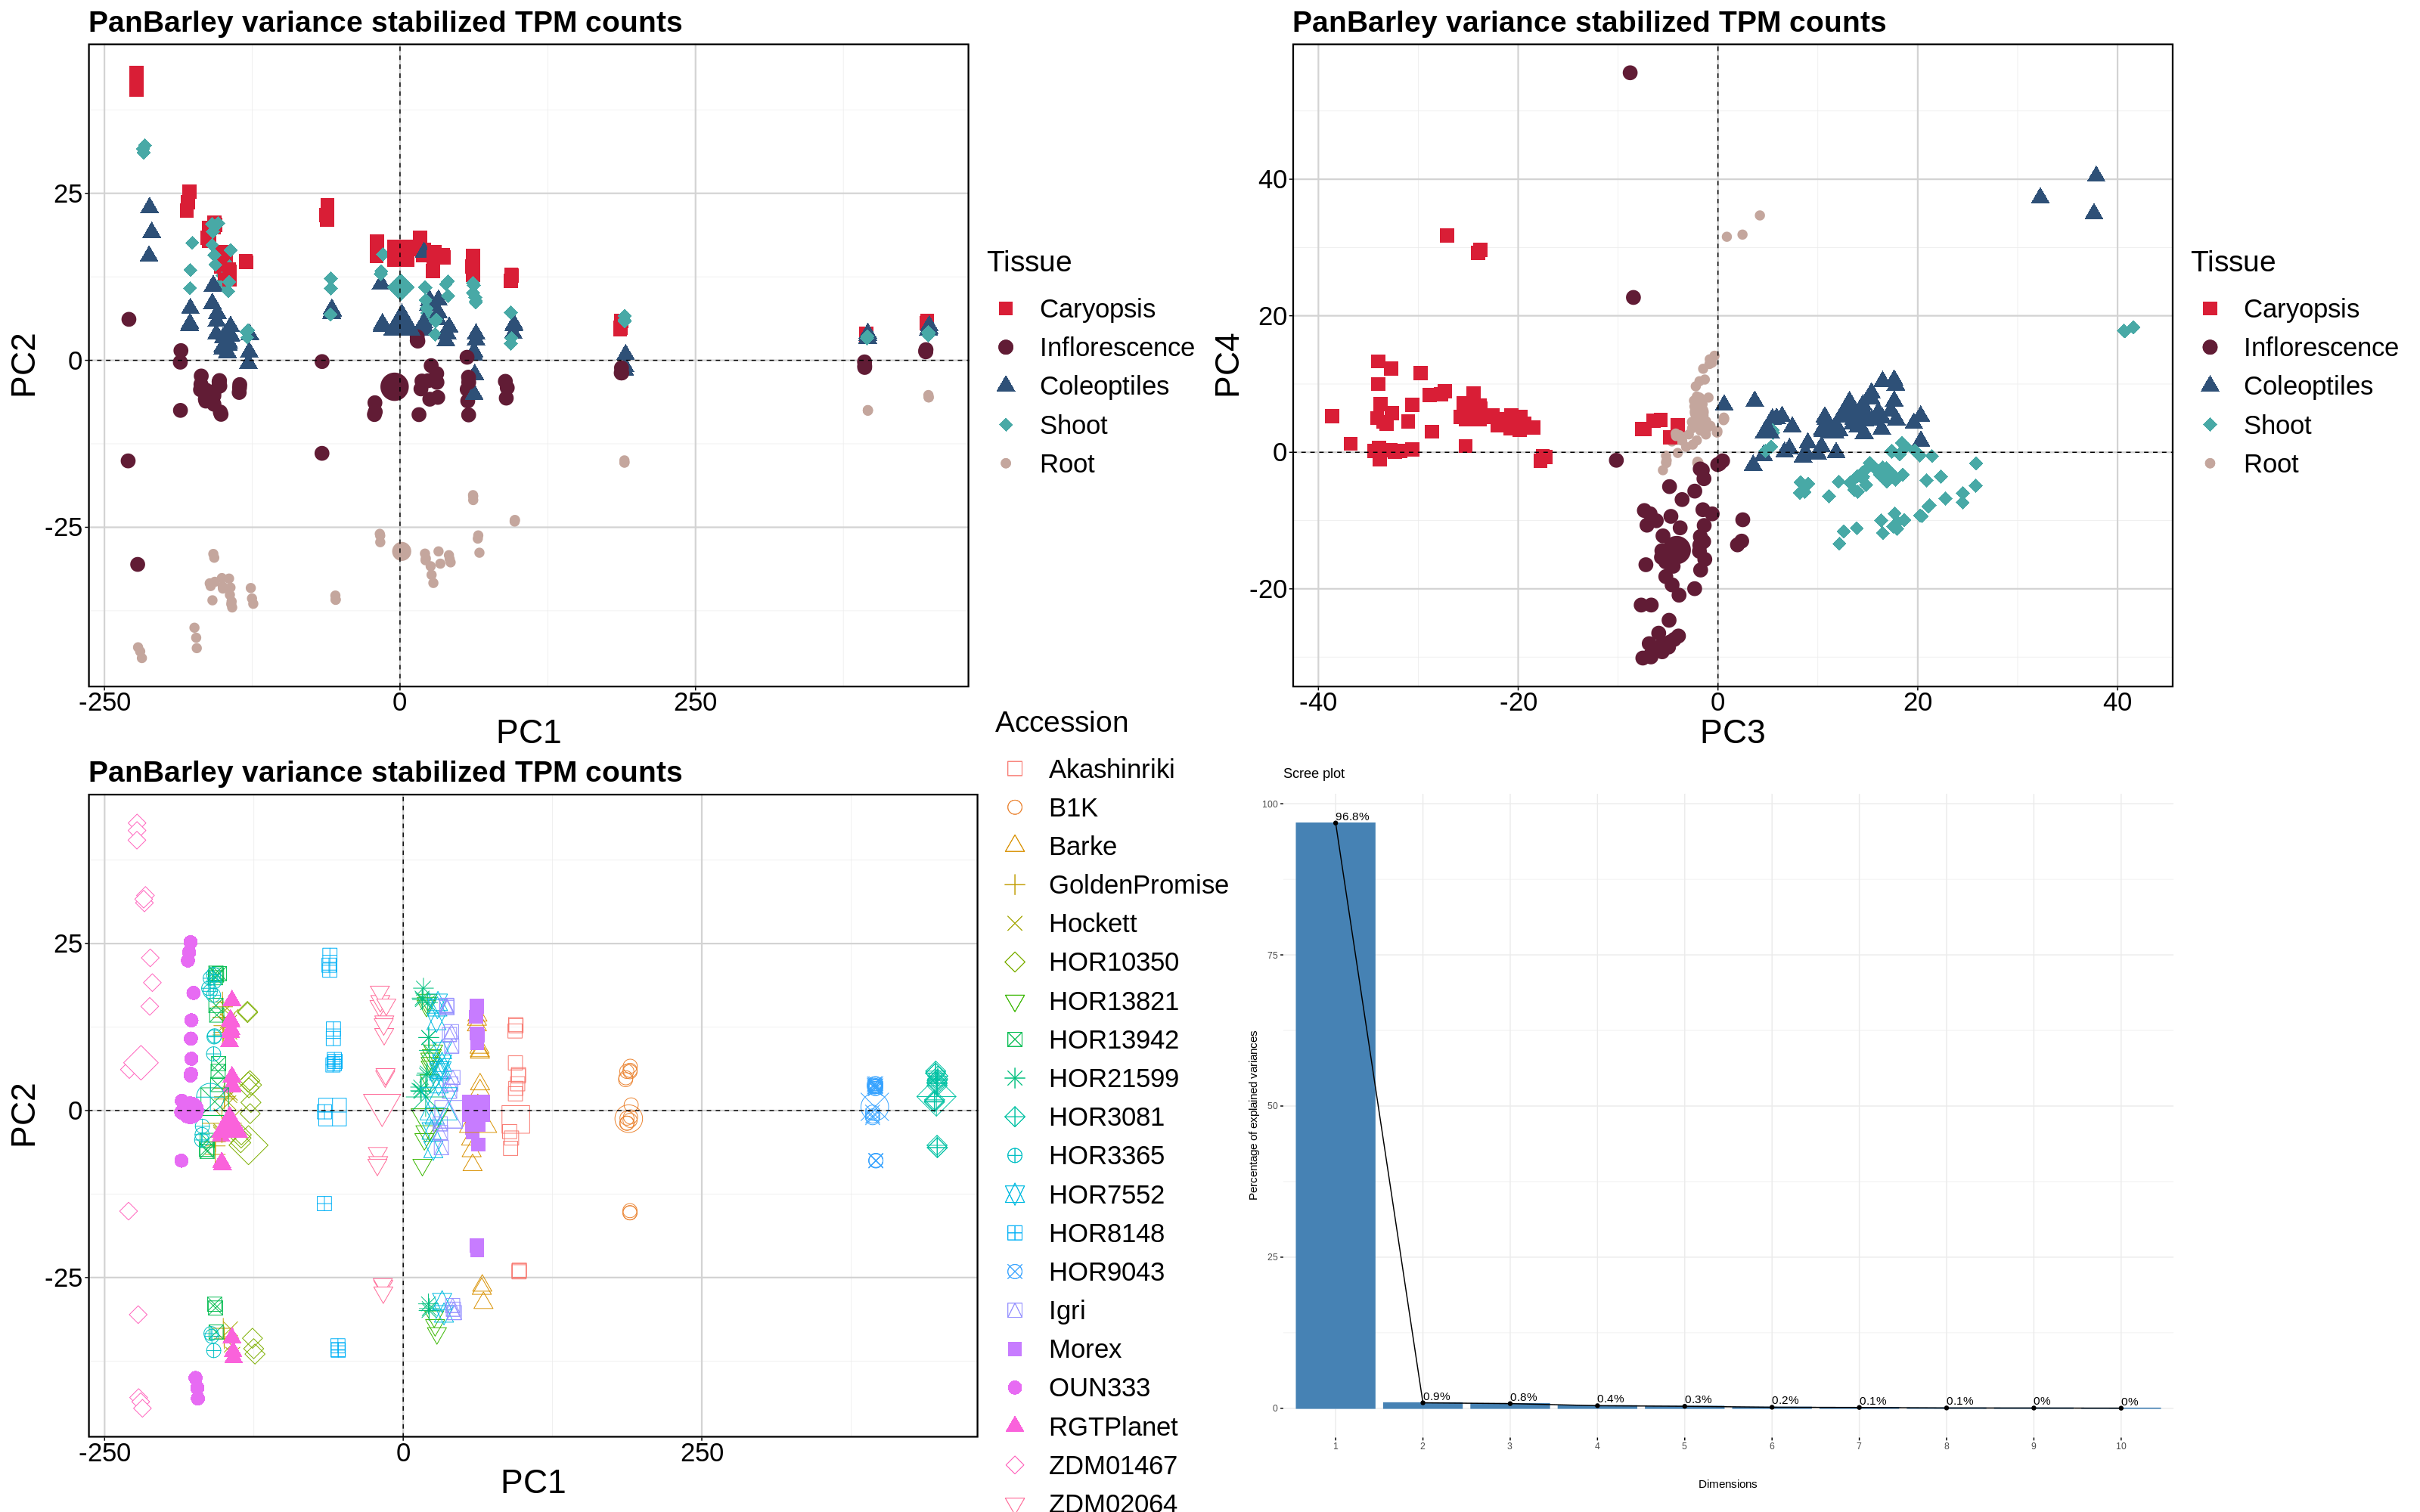

In [15]:
comp <- (pca1 + pca2) / (pca3 + scree)
options(repr.plot.width = 32, repr.plot.height = 20, repr.plot.res = 100)
comp

In [18]:
umap = cnt_pca[, grep("chr", colnames(cnt_pca))]
umap_labels = cnt_pca[1:8]
# create umap table
u <- umap(umap)
head(u)
# inspect table
head(u$layout, 3)
udf <- as.data.frame(u$layout)
#glimpse(udf)
# visualize
u1 <- ggplot(udf, aes(x = V1, y = V2, color = umap_labels$Tissue, shape = umap_labels$Accession)) + 
                labs(title= "PanBarley variance stabilized TPM counts", x ="UMAP1", y = "UMAP2") +
                geom_point(size = 5) +
                scale_color_manual(name = "Tissue", values = c("#D91E36", "#611C35", "#2E5077", "#48A9A6", "#C4A69D"), 
                                    limits = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                     labels = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root")) +
                scale_shape_manual(name = "Accession",
                                   values = c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,23,25)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6)))

k-nearest neighbors for 297 items with k=15
object components: indexes, distances
Note: nearest neighbors may be approximate

umap configuration parameters

           n_neighbors: 15

          n_components: 2

                metric: euclidean

              n_epochs: 200

                 input: data

                  init: spectral

              min_dist: 0.1

      set_op_mix_ratio: 1

    local_connectivity: 1

             bandwidth: 1

                 alpha: 1

                 gamma: 1

  negative_sample_rate: 5

                     a: 1.57694361269457

                     b: 0.895060718151928

                spread: 1

          random_state: 982265509

       transform_state: NA

                   knn: NA

           knn_repeats: 1

               verbose: FALSE

       umap_learn_args: NA

                method: naive

       metric.function: [function]



$layout
                        [,1]         [,2]
Akashinriki_Ca1   -12.667730 -1.295215056
Akashinriki_Ca2   -12.601472 -1.268284144
Akashinriki_Ca3   -12.718149 -1.248859992
Akashinriki_Co1   -13.105276 -1.331367114
Akashinriki_Co2   -13.195802 -1.283062637
Akashinriki_Co3   -13.054182 -1.420413843
Akashinriki_In1   -13.076316 -1.333873335
Akashinriki_In2   -13.241331 -1.422181113
Akashinriki_In3   -13.112817 -1.403983467
Akashinriki_Ro1   -13.391876 -1.614388381
Akashinriki_Ro2   -13.428560 -1.652824420
Akashinriki_Ro3   -13.478175 -1.696870523
Akashinriki_Sh1   -13.235466 -1.562164530
Akashinriki_Sh2   -13.146867 -1.298014450
Akashinriki_Sh3   -13.152586 -1.485435946
B1K.04.12_Ca1     -23.259062 14.498073373
B1K.04.12_Ca2     -23.336141 14.425377639
B1K.04.12_Ca3     -23.191631 14.562390870
B1K.04.12_Co1     -23.082484 14.655560374
B1K.04.12_Co2     -23.051814 14.702665060
B1K.04.12_Co3     -23.273018 14.492041565
B1K.04.12_In1     -23.317672 14.441922726
B1K.04.12_In2     -23.3924

Akashinriki_Ca1,-12.66773,-1.295215
Akashinriki_Ca2,-12.60147,-1.268284
Akashinriki_Ca3,-12.71815,-1.248860


Rows: 297
Columns: 2
$ V1 <dbl> -12.66773, -12.60147, -12.71815, -13.10528, -13.19580, -13.05418, -…
$ V2 <dbl> -1.295215, -1.268284, -1.248860, -1.331367, -1.283063, -1.420414, -…


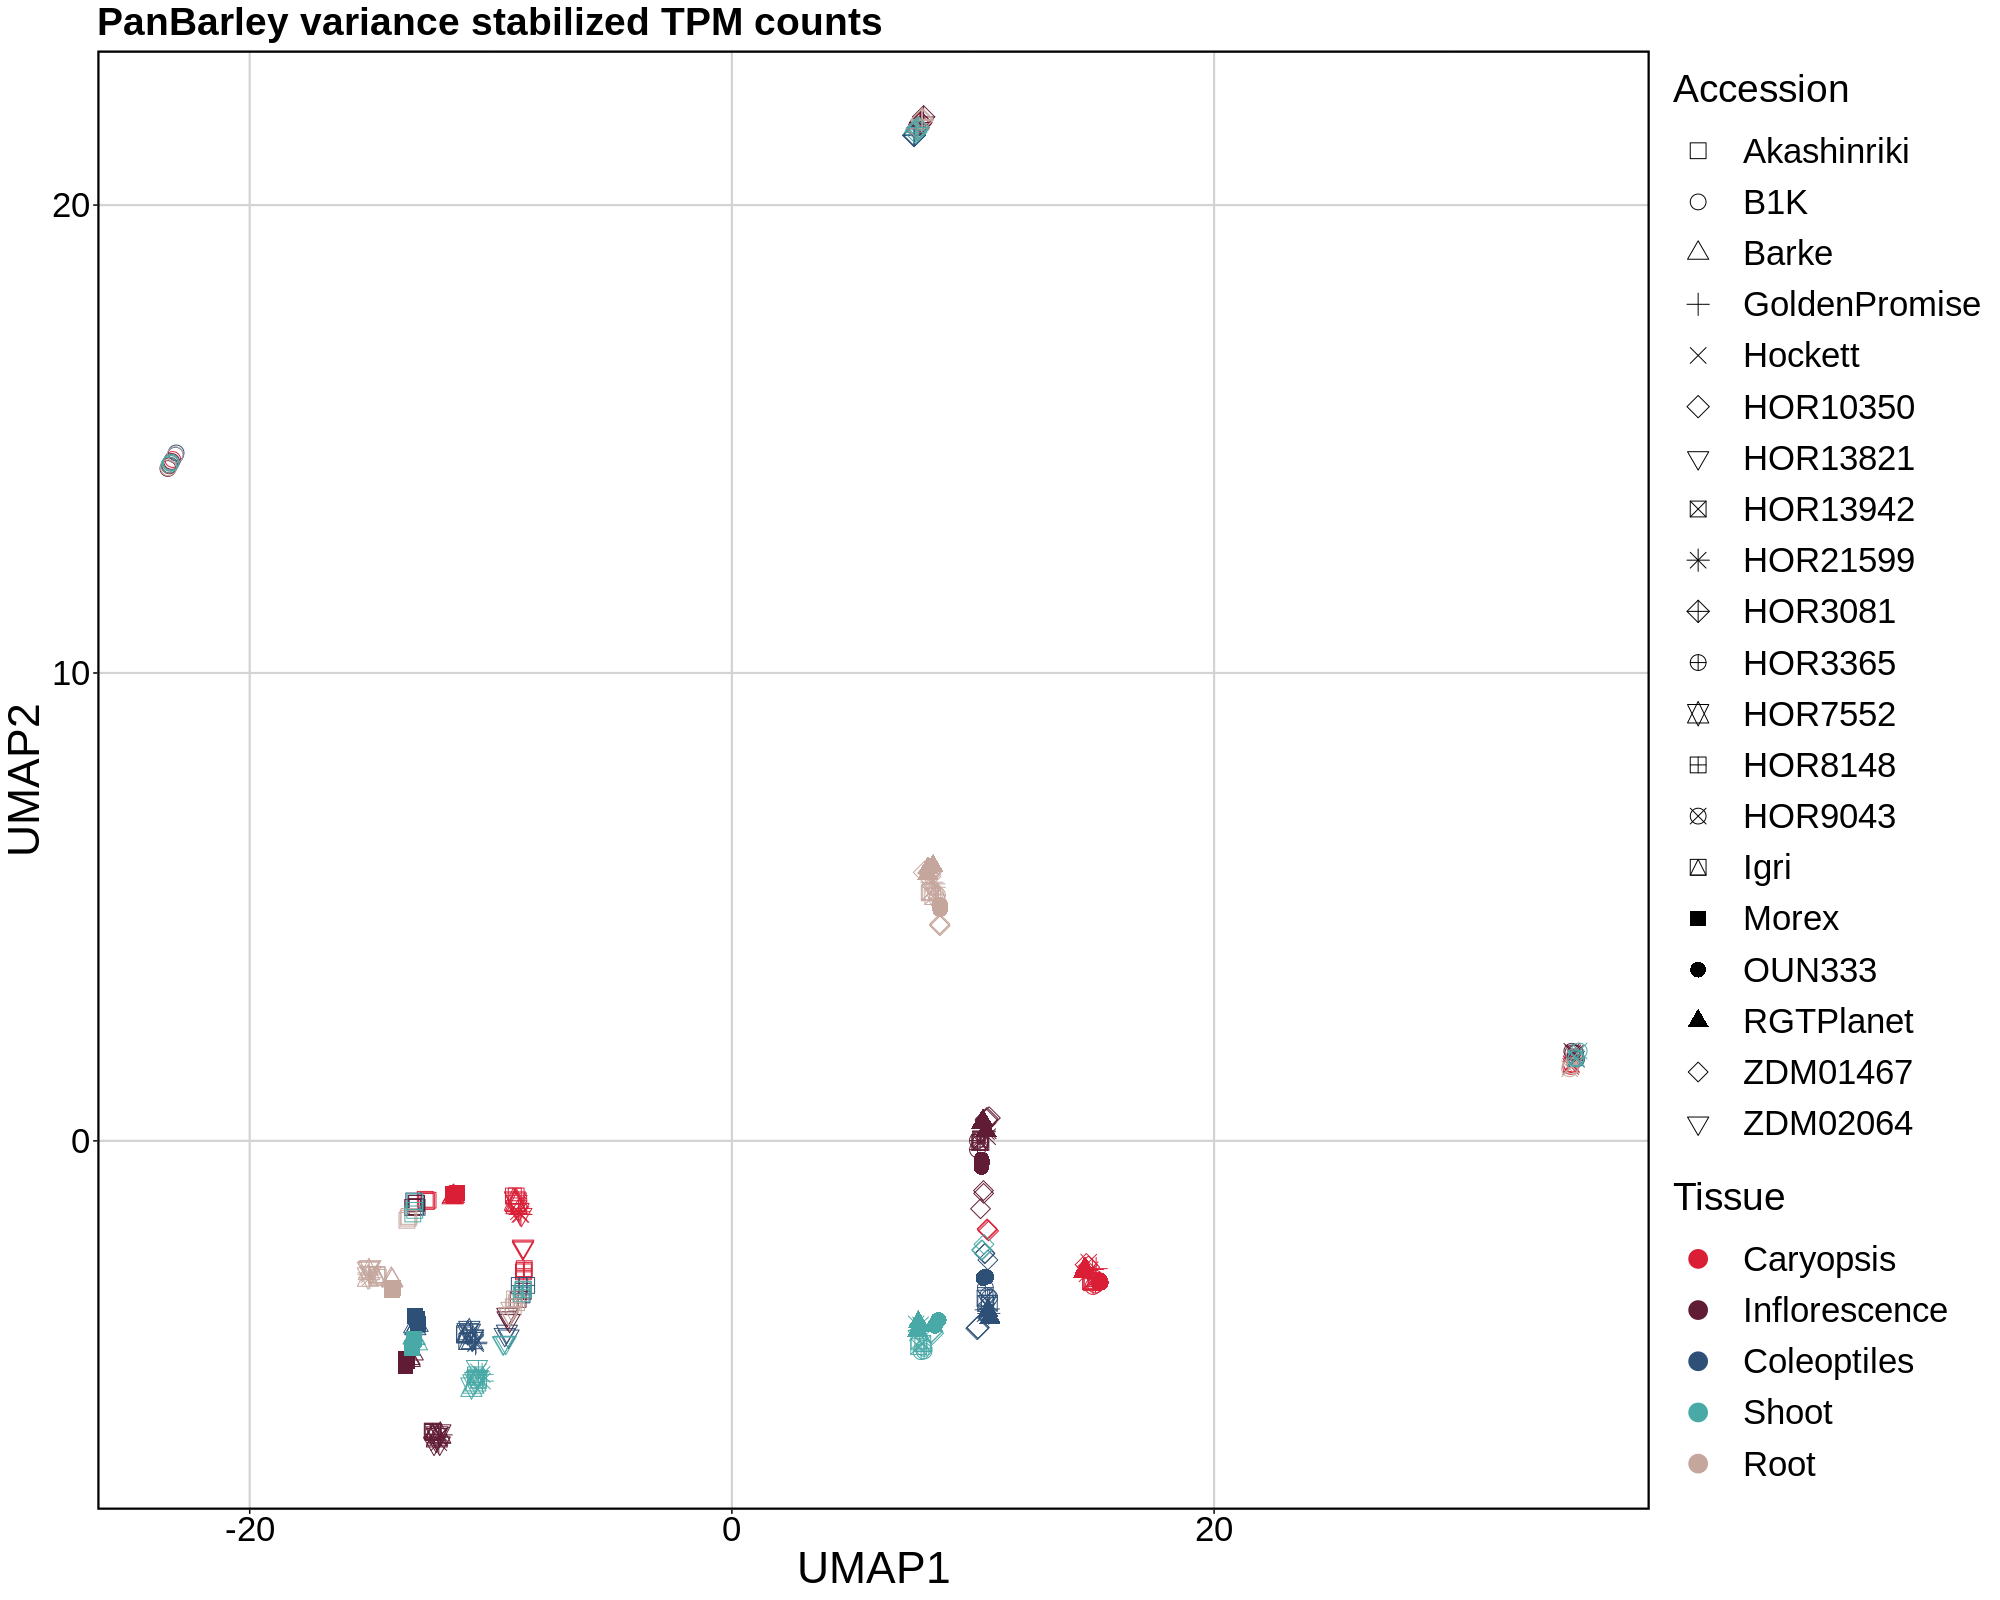

In [25]:
options(repr.plot.width = 20, repr.plot.height = 16, repr.plot.res = 100)
u1

In [ ]:
sessionInfo()